### Community Detection

Now we apply community detection algorithms to the active network data. For this part, we are trying to find communities purely based on the structure of the network.


In [1]:
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import community
from networkx.algorithms.community import modularity
import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

%matplotlib inline

In [2]:
# Reading the survey active network data

s_people = pd.read_csv('active_survey_new.csv')
len(s_people)


581

In [4]:
len(s_people['Employee ID_recipient'].unique())

76

In [7]:
G =nx.from_pandas_edgelist(s_people, source="Employee ID_recipient", target="Employee ID_adviser", 
                           edge_attr=["advice area count"] , create_using=nx.Graph())
len(list(G.nodes()))

111

In [8]:
hr_df = pd.read_csv('active_hr_new.csv')
hr_df.head()

,Employee ID,On Site Frequency,Position Title,Date in service,Business Unit level 1,Business Unit level 2
0,3022906,Fully Remote,Sr. Software Development Engineer II,2022-07-18,Corporate,Engineering - Brand 2
1,3031509,Fully Remote,Sr. Digital Marketing Specialist II,2022-12-05,Corporate,Marketing
2,2003115,Hybrid,Social Media Specialist I,2021-03-01,Brand 2,Marketing - Brand 2
3,3023646,Fully Remote,Product Specialist II,2022-08-01,Corporate,Engineering - Brand 2
4,3018469,Hybrid,Corporate Attorney,2021-11-22,Corporate,Legal


In [11]:

abr = []
for i in list(hr_df['Business Unit level 2']):
    if i == 'Customer Service - Brand 2':
        abr.append('CS_SF')
    elif i == 'Engineering - Brand 2':
        abr.append('ENG_SF')
    elif i == 'Marketing - Brand 2':
        abr.append('MKT_SF')
    elif i == 'Product Merchandising - Brand 2':
        abr.append('PM_SF')
    elif i == 'Sales - Brand 2':
         abr.append('Sales_SF')
    elif i == 'Leadership':
         abr.append('Leadership')
    elif i == 'Marketing':
         abr.append('MKT_Corp')
    elif i == 'Technology':
        abr.append('Tech_Corp')
    elif i == 'Legal':
        abr.append('Legal_Corp')
    elif i == 'Finance':
        abr.append('Finance_Corp')
    elif i == 'Supply Chain':
        abr.append('SPC_Crop')
    elif i == 'Human Resources':
        abr.append('HR_Corp')
    elif i == 'Enterprise Information Systems':
        abr.append('EIS_Corp')
    elif i == 'Manufacturing-Brand 1':
        abr.append('MF_Op')
    elif i == 'Environmental Health & Safety':
        abr.append('EnHS_Op')
    else:
        abr.append('MaTech_Op')


hr_df['team_abr'] = abr

### Setting Attributes for each node in the Graph

Each node in the graph contains the attributes:

* "Employee ID": the organization employee's ID
* "Team_L1:" the organization business units at level 1
* "Team_L2:" the organization business units at level 2

In [12]:


attrs = {}
for i in range(len(hr_df)):
    attrs[hr_df['Employee ID'][i]] = {'Employee ID': hr_df['Employee ID'][i], 
                                      'Team_L1' : hr_df['Business Unit level 1'][i],
                                      'Team_L2' : hr_df['Business Unit level 2'][i],
                                      'Abbr' : hr_df['team_abr'][i]
                                      }

attrs
nx.set_node_attributes(G, attrs)

The edges contain the advice topic count in the survey as a edge attribute

In [13]:
list(G.edges(data=True))[0:5]

[(3029869, 2002956, {'advice area count': 3}),
 (3029869, 2002210, {'advice area count': 2}),
 (3029869, 2003173, {'advice area count': 2}),
 (3029869, 2003137, {'advice area count': 2}),
 (3029869, 2003186, {'advice area count': 1})]

##### Extract the largest connected component from the graph.

In [14]:
# Extract the largest connected component of the original dataset
G = G.subgraph(max(nx.connected_components(G), key=len))
# stores the number of nodes in this graph
N = G.number_of_nodes()
N

111

Conclusiton: The result shows that there is a large single component (the giant component) that fills the network

##### Treat teams/departments as communityes

First, we think of team domains as communities

In [15]:
# set of unique community labels
list_of_communities = set() # set of unique community labels
# number of communities in total


for i in range(111):
    domain = list(G.nodes(data=True))[i][1]['Team_L2']
    if domain not in list_of_communities:
        list_of_communities.update([domain])
N = len(list_of_communities)
N
list_of_communities

{'Customer Service - Brand 2',
 'Engineering - Brand 2',
 'Enterprise Information Systems',
 'Environmental Health & Safety',
 'Finance',
 'Human Resources',
 'Leadership',
 'Legal',
 'Manufacturing Technology',
 'Manufacturing-Brand 1',
 'Marketing',
 'Marketing - Brand 2',
 'Product Merchandising - Brand 2',
 'Sales - Brand 2',
 'Supply Chain',
 'Technology'}

##### How many nodes does each community have?

In [17]:
from collections import Counter

# a Counter object with the format {community_name: number_of_nodes}
cnt = Counter()
for name in [list(G.nodes(data=True))[i][1]['Team_L2'] for i in range(111)]:
    cnt[name] += 1
dict_num_community = cnt
dict_num_community

Counter({'Customer Service - Brand 2': 28,
         'Engineering - Brand 2': 27,
         'Marketing - Brand 2': 16,
         'Marketing': 9,
         'Product Merchandising - Brand 2': 8,
         'Supply Chain': 4,
         'Sales - Brand 2': 3,
         'Manufacturing Technology': 2,
         'Leadership': 2,
         'Legal': 2,
         'Finance': 2,
         'Environmental Health & Safety': 2,
         'Enterprise Information Systems': 2,
         'Manufacturing-Brand 1': 2,
         'Technology': 1,
         'Human Resources': 1})

In [18]:
hr_df['team_abr'].unique()

array(['ENG_SF', 'MKT_Corp', 'MKT_SF', 'Legal_Corp', 'PM_SF', 'CS_SF',
       'MF_Op', 'Leadership', 'EnHS_Op', 'Finance_Corp', 'EIS_Corp',
       'SPC_Crop', 'Sales_SF', 'MaTech_Op', 'HR_Corp', 'Tech_Corp'],
      dtype=object)

In [19]:
tuples = []
for i in list(dict_num_community.keys()):
    df = hr_df[hr_df['Business Unit level 2'] == i]
    l = tuple(df['Employee ID'])
    tuples.append(l)
tuples
communities = set(map(frozenset, tuples))

In [20]:
hr_df['team_abr'].value_counts()

team_abr
CS_SF           28
ENG_SF          27
MKT_SF          16
MKT_Corp         9
PM_SF            8
SPC_Crop         4
Sales_SF         3
Legal_Corp       2
Leadership       2
MF_Op            2
Finance_Corp     2
EnHS_Op          2
EIS_Corp         2
MaTech_Op        2
HR_Corp          1
Tech_Corp        1
Name: count, dtype: int64

In [21]:
hr_df['Business Unit level 1'].unique()

array(['Corporate', 'Brand 2', 'Operations'], dtype=object)

In [22]:
def subset1(level2):
    sub = hr_df[hr_df['Business Unit level 2'] == str(level2)]
    return sub


def subset(level1):
    sub = hr_df[hr_df['Business Unit level 1'] == str(level1)]
    return sub

slr = subset1('Leadership')
seng = subset1('Engineering - Brand 2')
smt = subset1('Marketing - Brand 2')
spm = subset1('Product Merchandising - Brand 2')
ssale = subset1('Sales - Brand 2')
scs = subset1('Customer Service - Brand 2')

opera = subset('Operations')
corp_1 = subset('Corporate')
# exclude brand 2 enginnering and vp form corporate

corp_2 = corp_1[corp_1['Business Unit level 2'] != 'Engineering - Brand 2']
corp = corp_2[corp_2['Employee ID'] != 3040598]


In [23]:

tuples1 = []
for i in [seng, smt, spm, ssale, scs, opera, corp, slr]:
    l = tuple(i['Employee ID'])
    tuples1.append(l)
#communities_1 = set(map(frozenset, tuples1))

nodes_slr = list(slr['Employee ID'])
nodes_seng = list(seng['Employee ID'])
nodes_smt = list(smt['Employee ID'])
nodes_spm = list(spm['Employee ID'])
nodes_ssale = list(ssale['Employee ID'])
nodes_scs = list(scs['Employee ID'])
nodes_ope = list(opera['Employee ID'])
nodes_cor = list(corp['Employee ID'])


##### Measures of Partition Quality 
We used 5 ways to measure the quality of a partition: modularity, coverage, performance, separability, and density, which we modified from SIADS NetWork Analysis Course

Defining a helper function avg_measure(G, communities, measure) that computes the average value for a given measure over all communities in a graph.

In [24]:
# Calculate the average value of a given measure across communities in a graph.
def avg_measure(G, communities, measure):
    sum_ = 0
    for comm in communities:
        sum_ += measure(G, comm)
    return sum_ / len(communities)

Defining a function to measure the separability for a single community -- measure the ratio of intra-community to inter-community edges.

In [25]:
def separability_one_community(G, community):
    community_graph = G.subgraph(community)
    intra_num = community_graph.number_of_edges()
    inter_num = len(G.edges(community)) - intra_num
    
    # assign separability to it and return
    if inter_num == 0:
        result = intra_num
    else:
        result = intra_num/inter_num
    return result

Then, we can use avg_measure(G, communities, separability_one_community) to measure the separability of a partition.

Defining a function to measure the density of a single community -- the fraction of intra-community edges out of all possible edges.

In [26]:
def density_one_community(G, community):
    # If the community has only one node, just return 1
    if len(community) == 1: 
        return 1
    else:
        community_graph = G.subgraph(community)
        intra_num = community_graph.number_of_edges()
        values = community_graph.number_of_nodes()
        result = intra_num/(1/2*values*(values-1))
        # assign density to it and return 
        return result

Using avg_measure(G, communities, density_one_community) to measure the density of a partition.

##### What is the modularity, coverage, performance, density, and separability of this network using the team domain as a partition?

* The Modularity: A measure of the structure of networks or graphs which measures the strength of division of a network into modules. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.

* The coverage of a partition: The ratio of the number of intra-community edges to the total number of edges in the graph.

* The performance of a partition: The number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.

* The separability of a community: The ratio of intra-community edges to inter-community edges.

* The density of a community: The fraction of intra-community edges out of all possible edges.

##### Calculating the modularity, coverage, performance, density, and separability of this network that using the team domain as a partition

In [27]:
def q_measure(G, communities):
    mod = nx.algorithms.community.modularity(G, communities)
    quality = nx.algorithms.community.partition_quality(G, communities)
    cov = quality[0]
    perf = quality[1]
    sep = avg_measure(G, communities, separability_one_community)
    den = avg_measure(G, communities, density_one_community)
    return {'mod':mod, 'cov':cov, 'perf': perf, 'sep':sep, 'den':den}#mod, cov, perf, sep, den

In [29]:

communities_list = []
for i in list(list_of_communities):
    group = set()
    for j in range(111):
        if list(G.nodes(data=True))[j][1]['Team_L2'] == i:
            group.update([list(G.nodes(data=True))[j][1]['Employee ID']])
    communities_list.append(group)
mod = nx.algorithms.community.modularity(G, communities_list)
quality = nx.algorithms.community.partition_quality(G, communities_list)
cov = quality[0]
perf = quality[1]
sep = avg_measure(G, communities_list, separability_one_community)
den = avg_measure(G, communities_list, density_one_community)


In [30]:
# Team domain's modularity, coverage, performance, density, and separability
team_domain = q_measure(G, communities_list)
t_mod = team_domain['mod']
t_cov = team_domain['cov']
t_perf = team_domain['perf']
t_sep = team_domain['sep']
t_den = team_domain['den']
print(t_mod, t_cov, t_perf, t_sep, t_den)

0.37337967527018784 0.6081370449678801 0.8643734643734644 0.25850018037518036 0.29415127696377696


#### Community Detection Algorithms

We apply community detection algorithms to the Brand 2 organization network graph. For this part, we are trying to find communities purely based on the structure of the network.

The community detection algorithms, we are going to apply, including the Girvan-Newman, the label propagation algorithm, and the K-Clique. We will begin with the Girvan-Newman algorithm and pick the partition that results in the largest modularity, then the label propagation. Lastly, it would be the K-Clique.

##### Using Girvan_newman to find communities

Girvan-Newman Algorithm: for Community Detection, the communities in a graph are discovered by iteratively removing the edges of the graph according to the edge betweenness centrality value. The edge with the highest edge betweenness is removed first.


In [31]:
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)

In [32]:
len(communities[10])

12

In [33]:
#len(communities[54])
from random import randint
color = []

for i in range(14):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [34]:
# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    #colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    colors = color[:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


In [35]:
abbr = nx.get_node_attributes(G, "Abbr")


In [36]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(2, 1, i)
    plt.title(title, fontsize=20)
    nx.draw(
        graph,
        pos=pos,
        node_size=250,
        node_color=node_colors,
        edge_color= 'skyblue',
        with_labels=True,
        labels = abbr,
        font_size=8,
        font_weight = 'bold',
        font_color="black",
    )

In [40]:
len(communities[4])

6

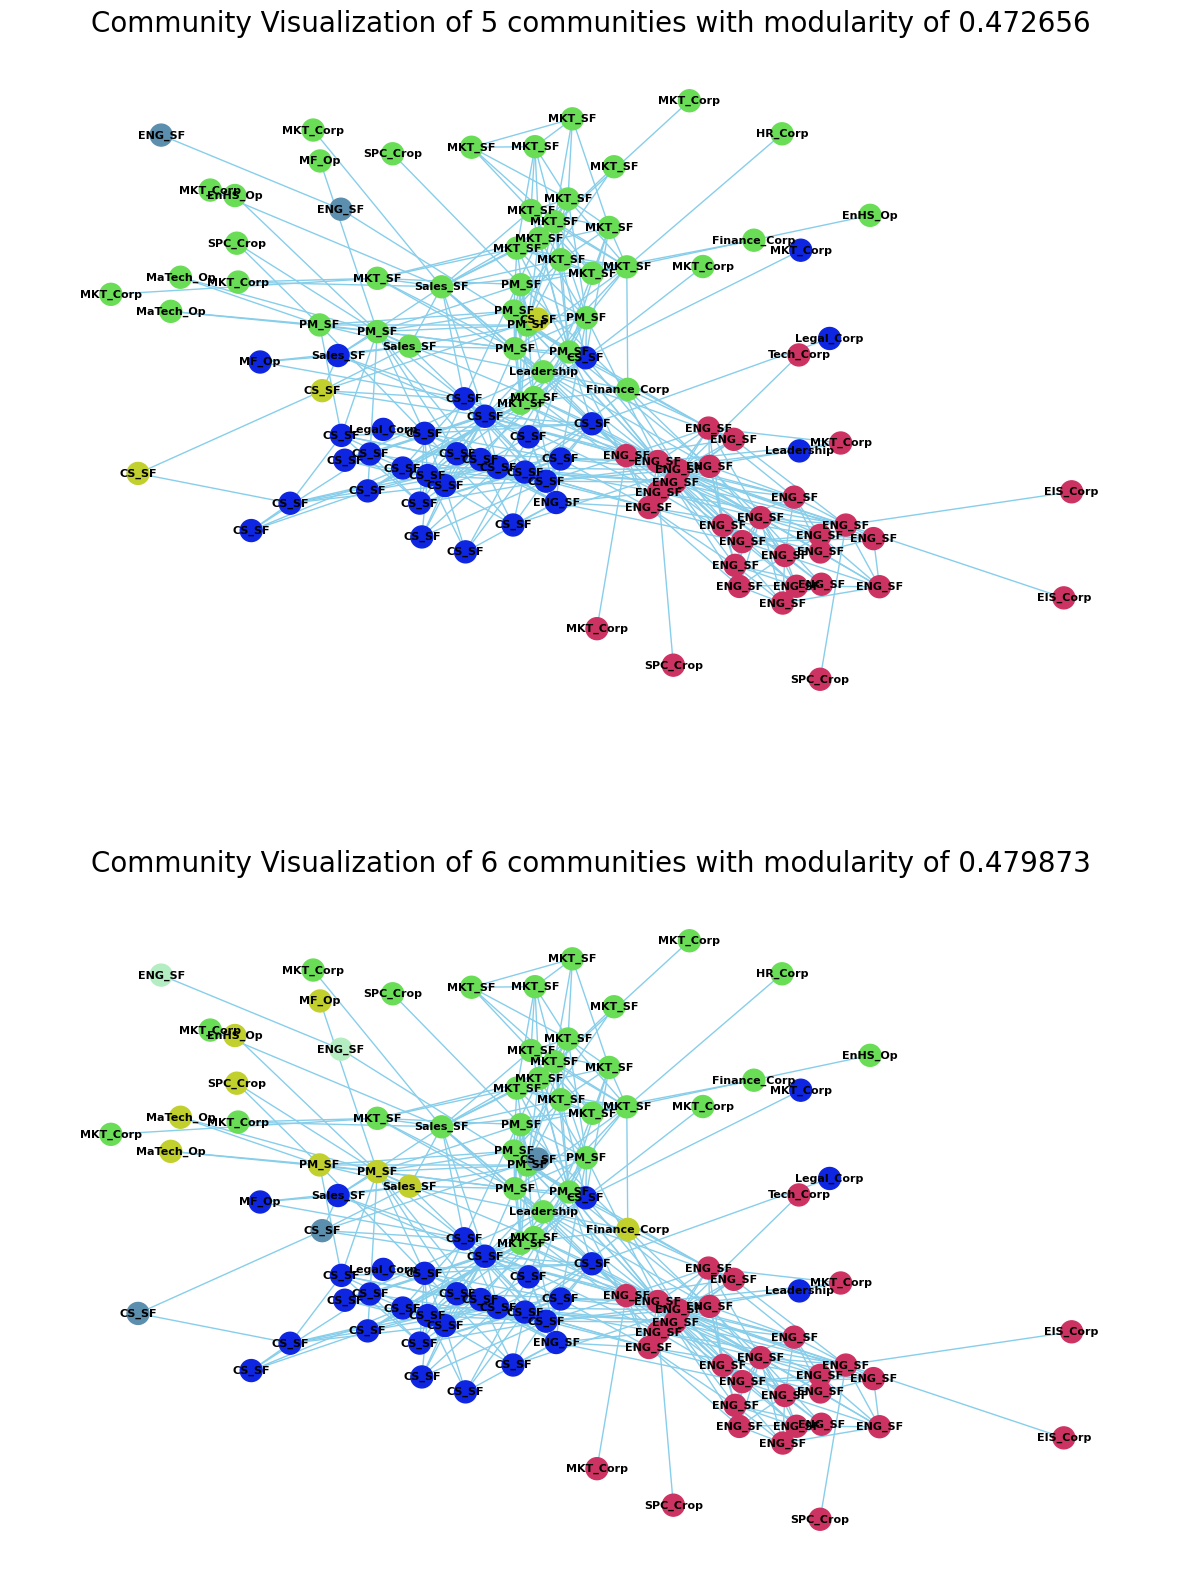

In [41]:
fig, ax = plt.subplots(2, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[3], 1)
visualize_communities(G, communities[4], 2)


plt.show()

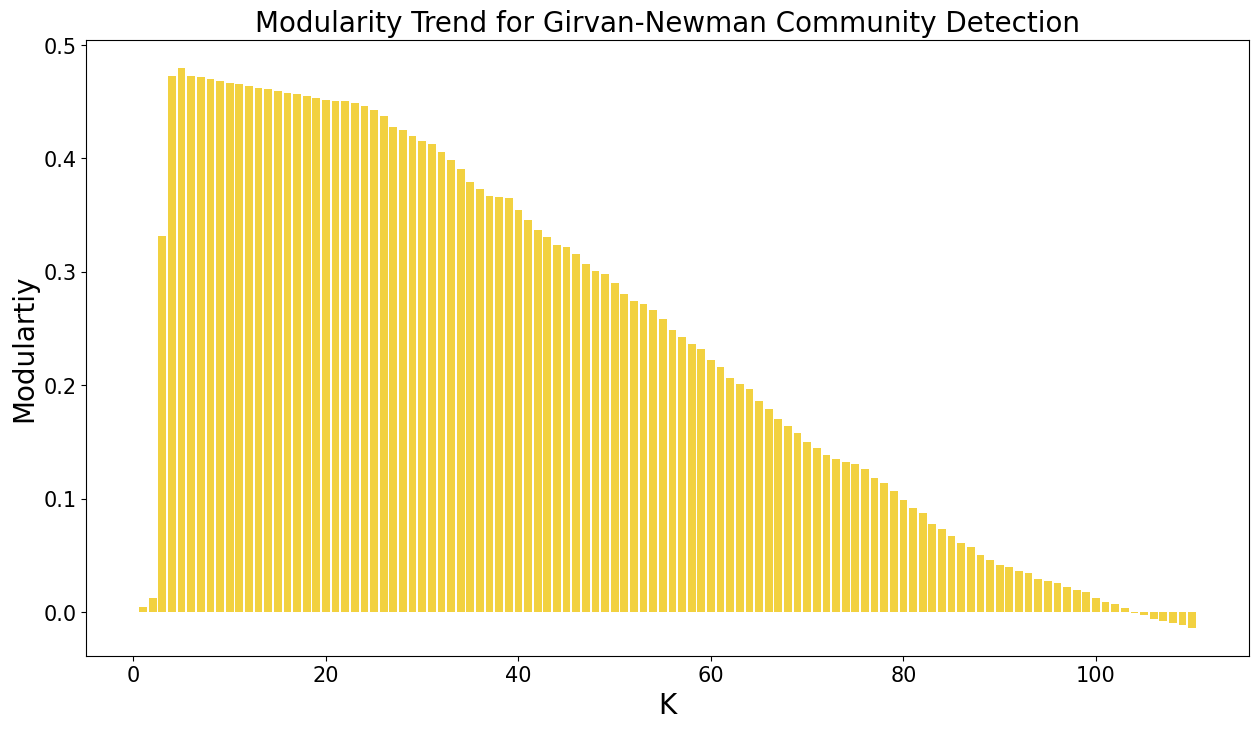

In [39]:
# Plot change in modularity as the important edges are removed

fig = plt.figure(figsize = (15, 8))

# creating the bar plot
plt.bar(x = list(modularity_df['k']), 
        height = list(modularity_df["modularity"]), 
        color ="#F2D140", 
        )

plt.xlabel("K", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Modulartiy", fontsize=20)
plt.title("Modularity Trend for Girvan-Newman Community Detection", fontsize=20)
plt.show()

##### Community detection result:

The result shows that dividing whole network into 6 communityies has a highest modularity of 0.48

In [42]:

start = time.time()

communities_generator = community.girvan_newman(G)
next_level_communities = ()
next_lists = []
mod_scores = []

while True:
    try:
        next_level_communities = next(communities_generator)
        mod = modularity(G, next_level_communities)
        next_lists.append(next_level_communities)
        mod_scores.append(mod)
    except StopIteration:
        break

end = time.time()
print("%.2f min ellapsed." % ((end - start)/60))

id_max = np.argmax(mod_scores)
max_mod_community = next_lists[id_max]

0.11 min ellapsed.


In [43]:
num_max_mod_communities = len(max_mod_community)
gn = q_measure(G, max_mod_community) 
dic = {}
dic['Method name'] = ['Girvan Newman', 'Greedy modularity maximization', 'Label propogation', 'Team domain']
dic['num_community'] = [num_max_mod_communities, 0, 0, 0]
dic['modularity'] = [gn['mod'], 0, 0, 0]
dic['coverage'] = [gn['cov'], 0, 0, 0]
dic['performance'] = [gn['perf'], 0, 0, 0]
dic['density'] = [gn['den'], 0, 0, 0]
dic['separability'] = [gn['sep'], 0, 0, 0]
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [6, 0, 0, 0],
 'modularity': [0.47987289592780935, 0, 0, 0],
 'coverage': [0.7708779443254818, 0, 0, 0],
 'performance': [0.7855855855855856, 0, 0, 0],
 'density': [0.44773350200295176, 0, 0, 0],
 'separability': [1.2989754299940222, 0, 0, 0]}

##### Using Clauset Newman Moore greedy modularity maximization, find a partition of the network and compute the number of communities in the partition and its modularity, coverage, performance, density, and separability.

In [44]:
gred_partition = nx.algorithms.community.greedy_modularity_communities(G)
num_community = len(list(gred_partition))
ahc_partition = list(gred_partition)
gred = q_measure(G, ahc_partition) 

dic['num_community'][1] = num_community
dic['modularity'][1] = gred['mod']
dic['coverage'][1] = gred['cov']
dic['performance'][1] = gred['perf']
dic['density'][1] = gred['den']
dic['separability'][1] = gred['sep']
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [6, 4, 0, 0],
 'modularity': [0.47987289592780935, 0.46882006887096545, 0, 0],
 'coverage': [0.7708779443254818, 0.7837259100642399, 0, 0],
 'performance': [0.7855855855855856, 0.7454545454545455, 0, 0],
 'density': [0.44773350200295176, 0.27183935296457984, 0, 0],
 'separability': [1.2989754299940222, 1.5624679701426025, 0, 0]}

##### Finding a partition of the network with the label propagation algorithm and compute the number of communities in the partition and its modularity, coverage, performance, denisty, and separability.

In [45]:
lp_generator = nx.algorithms.community.label_propagation.label_propagation_communities(G)
lp_partition = list(lp_generator)
num_community = len(lp_partition)
lp = q_measure(G, lp_partition) 


dic['num_community'][2] = num_community
dic['modularity'][2] = lp['mod']
dic['coverage'][2] = lp['cov']
dic['performance'][2] = lp['perf']
dic['density'][2] = lp['den']
dic['separability'][2] = lp['sep']
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [6, 4, 3, 0],
 'modularity': [0.47987289592780935,
  0.46882006887096545,
  0.33713529797468017,
  0],
 'coverage': [0.7708779443254818, 0.7837259100642399, 0.8629550321199143, 0],
 'performance': [0.7855855855855856,
  0.7454545454545455,
  0.5561015561015561,
  0],
 'density': [0.44773350200295176, 0.27183935296457984, 0.4267964593545989, 0],
 'separability': [1.2989754299940222,
  1.5624679701426025,
  2.439070767195767,
  0]}

In [46]:
#0.37337967527018784 0.6081370449678801 0.8643734643734644 0.25850018037518036 0.29415127696377696
dic['num_community'][3] = 8
dic['modularity'][3] = 0.373379
dic['coverage'][3] = 0.608137
dic['performance'][3] = 0.864373
dic['density'][3] = 0.258500
dic['separability'][3] = 0.294151
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [6, 4, 3, 8],
 'modularity': [0.47987289592780935,
  0.46882006887096545,
  0.33713529797468017,
  0.373379],
 'coverage': [0.7708779443254818,
  0.7837259100642399,
  0.8629550321199143,
  0.608137],
 'performance': [0.7855855855855856,
  0.7454545454545455,
  0.5561015561015561,
  0.864373],
 'density': [0.44773350200295176,
  0.27183935296457984,
  0.4267964593545989,
  0.2585],
 'separability': [1.2989754299940222,
  1.5624679701426025,
  2.439070767195767,
  0.294151]}

##### Create and print a pandas DataFrame where each row represents a community detection algorithm and each column is a quality measure.

In [47]:
compare = pd.DataFrame.from_dict(dic)

compare

,Method name,num_community,modularity,coverage,performance,density,separability
0,Girvan Newman,6,0.479873,0.770878,0.785586,0.447734,1.298975
1,Greedy modularity maximization,4,0.468820,0.783726,0.745455,0.271839,1.562468
2,Label propogation,3,0.337135,0.862955,0.556102,0.426796,2.439071
3,Team domain,8,0.373379,0.608137,0.864373,0.258500,0.294151


##### Cliques
In the densest neighborhoods of a network, it is sometimes possible to find groups of nodes that are all connected to each other. Such groups are called cliques.

In community detection, a **maximum clique** refers to the largest subset of vertices in a graph where every pair of vertices is connected by an edge. This means that within this subset, every member is directly connected to every other member, forming a complete subgraph.

##### Key Points about Maximum Cliques:
1. **Definition**: A clique is a subset of vertices such that every two distinct vertices are adjacent. A maximum clique is the largest possible clique in the graph.

2. **Applications**: Maximum cliques are used in various applications, including social network analysis, where they help identify tightly-knit groups or communities.


In [48]:
cliques = list(nx.find_cliques(G))

Text(0.5, 1.0, 'The maximal clique')

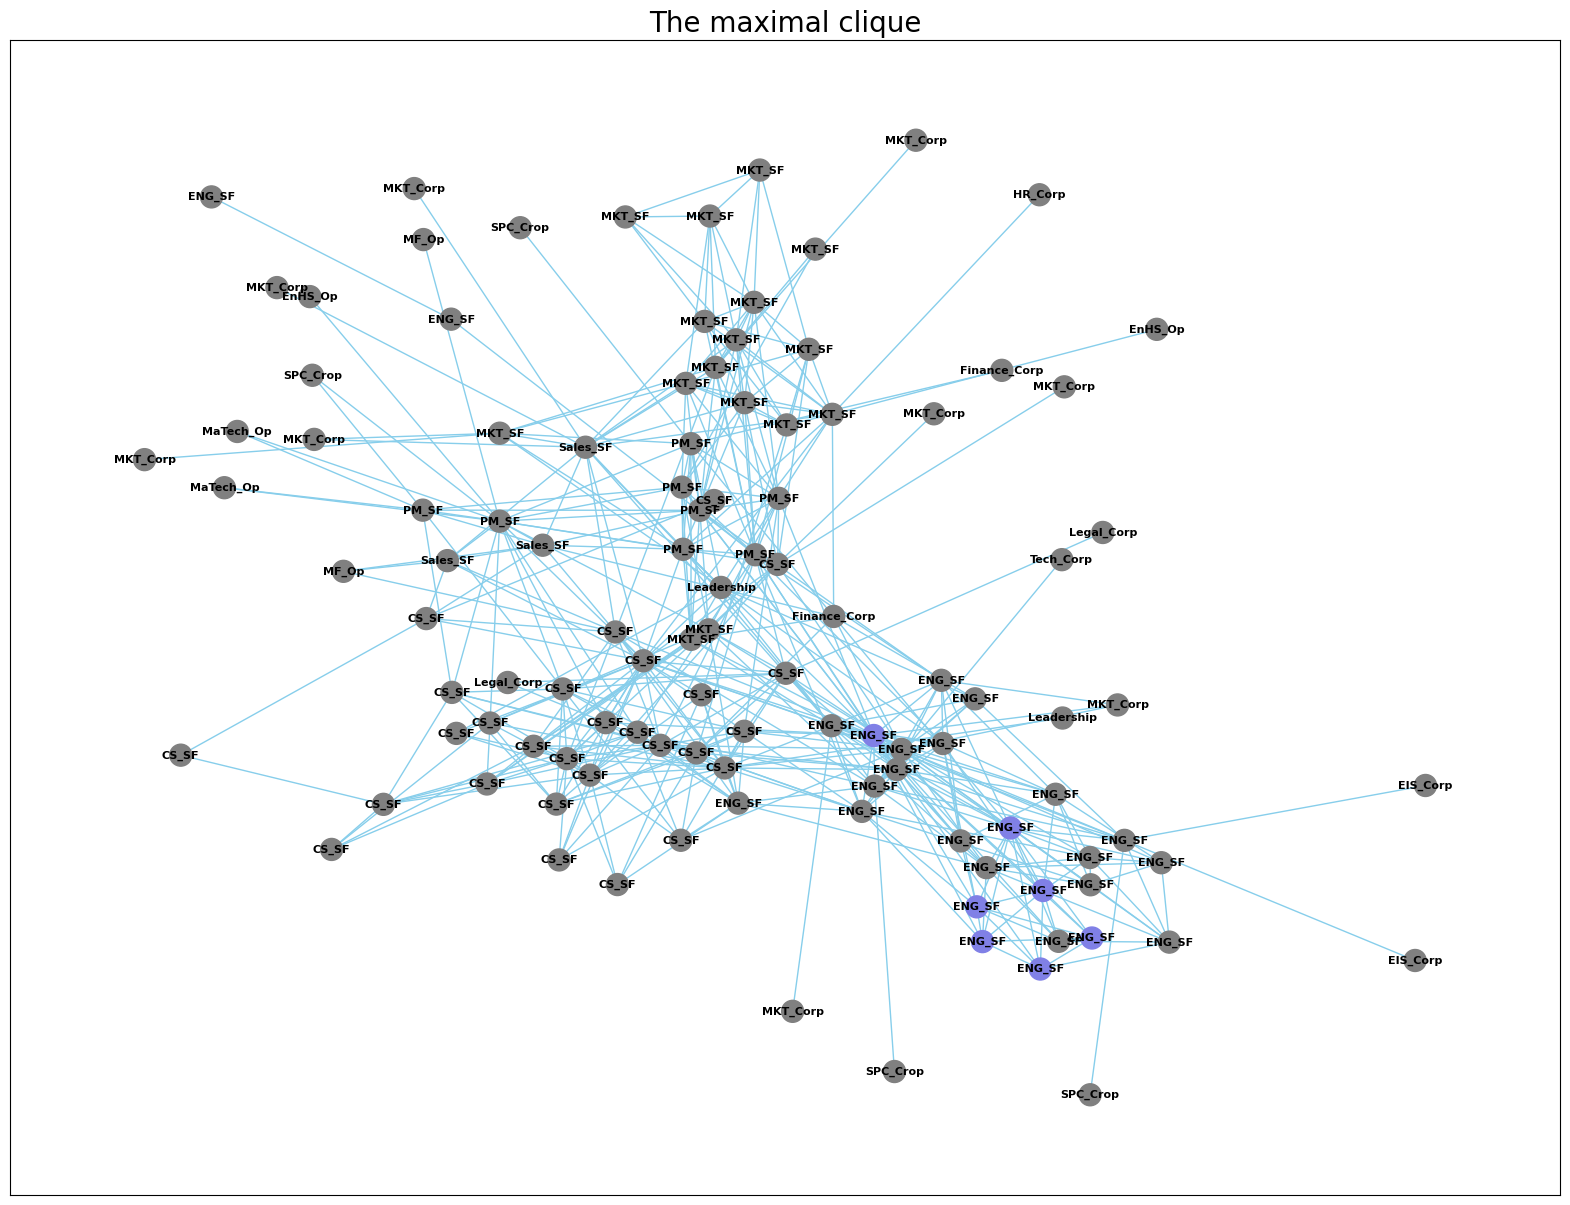

In [49]:
#Find max clique
max_clique = max(cliques, key=len)


fig = plt.figure(figsize = (20, 15))
# Visualize maximum clique
node_color = [(0.5, 0.5, 0.5) for v in G.nodes()]
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=2)
for i, v in enumerate(G.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
nx.draw_networkx(G,
        pos=pos,
        node_size=250,
        node_color=node_color,
        edge_color= 'skyblue',
        with_labels=True,
        labels = abbr,
        font_size=8,
        font_weight = 'bold',
        font_color="black",)
plt.title('The maximal clique', fontsize = 20)

In [52]:
#tightly-knit groups

tk_group = hr_df[hr_df['Employee ID'].isin(max_clique)]
tk_group

,Employee ID,On Site Frequency,Position Title,Date in service,Business Unit level 1,Business Unit level 2,team_abr
28,3031524,Fully Remote,"Director, Engineering",2022-11-28,Corporate,Engineering - Brand 2,ENG_SF
29,3025961,Fully Remote,Sr. Software Development Engineer I,2022-08-29,Corporate,Engineering - Brand 2,ENG_SF
47,2002937,Hybrid,Sr. Software Development Engineer I,2016-06-23,Corporate,Engineering - Brand 2,ENG_SF
52,3043340,Fully Remote,Software Development Engineer II,2024-02-20,Corporate,Engineering - Brand 2,ENG_SF
69,2002605,Hybrid,Product Manager,2016-03-02,Corporate,Engineering - Brand 2,ENG_SF
81,3034698,Fully Remote,Sr. Software Development Engineer I,2023-07-10,Corporate,Engineering - Brand 2,ENG_SF
91,3043896,Fully Remote,"Sr. Manager, Engineering",2024-04-01,Brand 2,Engineering - Brand 2,ENG_SF


##### Insight:

A maximum clique in this network would represent a group of employees where each person directly collaborates with every other person in the group. Identifying such cliques can help in understanding the core teams or highly collaborative groups within the organization.

From the maxumum cluque network graph and tt_group dataframe, we identified a tightly-knit group that is comprised of 7 members in Engineering team.

##### K-Core

In larger networks, k-cores can be a practical alternative for finding dense regions. A k-core is created by removing all nodes of degree less than k from a network. The number k can be anything you choose. The larger k is, the more nodes will be stripped away.

A **k-core** is a subgraph in which every vertex(node) has at least \( k \) connections (degree) to other vertices(nodes) within the subgraph. It helps identify the most interconnected and cohesive parts of a network. Here are some key points about k-cores:

1. **Definition**: A k-core is a maximal subgraph where each vertex has a degree of at least \( k \)¹². This means that within this subgraph, every node is connected to at least \( k \) other nodes.

2. **Identification**: To find a k-core, you iteratively remove all vertices with a degree less than \( k \) until no more vertices can be removed.

3. **Applications**:
   - **Community Detection**: K-cores can help identify tightly-knit communities within larger networks¹.
   - **Network Robustness**: Analyzing k-cores can provide insights into the robustness and resilience of a network.
   - **Influence Spread**: In social networks, k-cores can highlight influential groups or individuals who are well-connected.


In [53]:
sorted(G.degree, key=lambda x: x[1], reverse=True)

[(2002605, 26),
 (2002394, 26),
 (2003173, 25),
 (2003018, 21),
 (3020739, 20),
 (3029869, 19),
 (3021660, 19),
 (3031524, 19),
 (2002956, 18),
 (3027478, 18),
 (2003209, 17),
 (2003156, 17),
 (2003036, 17),
 (2003186, 15),
 (2002895, 15),
 (2003155, 15),
 (2003137, 14),
 (2003148, 14),
 (2003000, 14),
 (2002166, 13),
 (2003109, 13),
 (2002910, 13),
 (3043751, 13),
 (2002893, 13),
 (3007231, 13),
 (3023646, 13),
 (3044041, 12),
 (2003133, 12),
 (2002909, 12),
 (2002643, 12),
 (3022260, 12),
 (3044059, 12),
 (3029900, 11),
 (3040598, 11),
 (3029814, 11),
 (3033414, 11),
 (2002724, 11),
 (2003193, 11),
 (3042755, 11),
 (2003136, 10),
 (2002937, 10),
 (3034698, 10),
 (3042739, 10),
 (3029400, 10),
 (3022812, 10),
 (2003112, 10),
 (2003115, 9),
 (2002934, 9),
 (2002939, 9),
 (3023032, 9),
 (2002435, 9),
 (3022906, 8),
 (3042370, 8),
 (3030382, 8),
 (2002210, 8),
 (2003199, 8),
 (3043896, 8),
 (2002936, 8),
 (2003191, 8),
 (2002680, 7),
 (2002620, 7),
 (3029366, 7),
 (3038672, 7),
 (3025961

Text(0.5, 1.0, '5-core and 7-core in the Brand 2 Organization network')

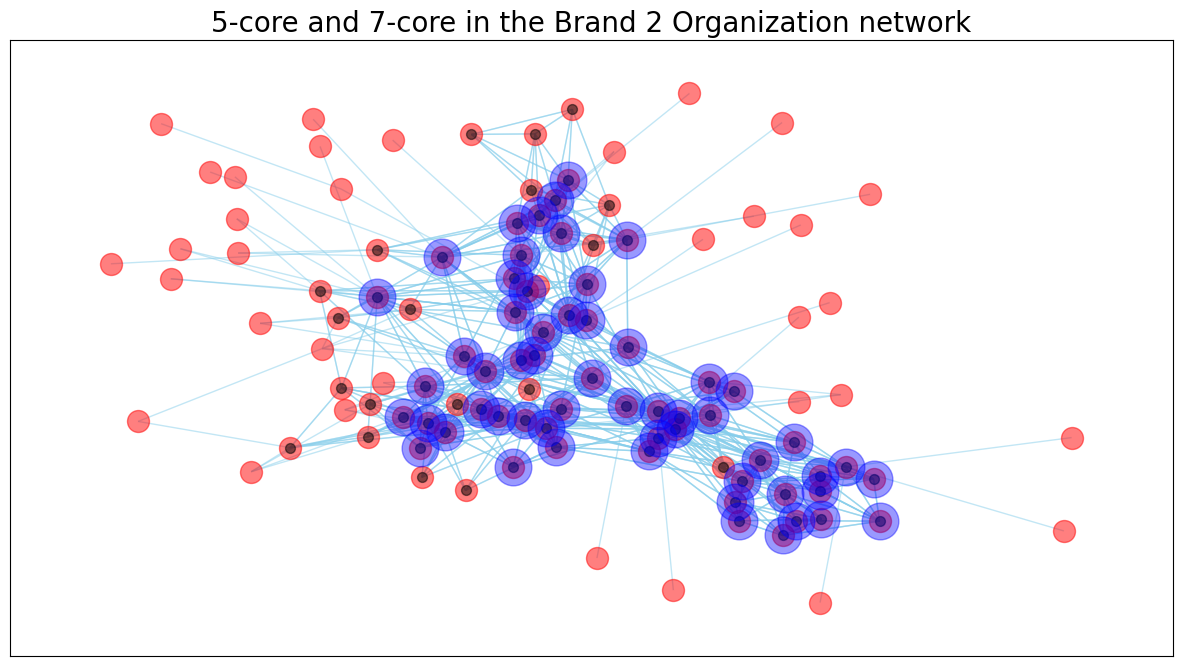

In [60]:
# Find k-cores
G_core_5 = nx.k_core(G, 5)
G_core_7 = nx.k_core(G, 7)

# Visualize network and k-cores
fig = plt.figure(figsize = (15, 8))
nx.draw_networkx(
    G, pos=pos, node_size=250, label='Entirety',
    node_color="red", alpha=0.5, with_labels=False, edge_color='skyblue'
    )
nx.draw_networkx(
    G_core_5, pos=pos, node_size=50, label='5 Core',
    node_color="black", alpha=0.5, with_labels=False, edge_color='skyblue'
    )
nx.draw_networkx(
    G_core_7, pos=pos, node_size=700, label = '7 Core',
    node_color="blue", alpha=0.4, with_labels=False, edge_color='skyblue'
    )
plt.title('5-core and 7-core in the Brand 2 Organization network', fontsize=20)

In [62]:
# hr information regarding the 6-core subgraph

hr_core7 = hr_df[hr_df['Employee ID'].isin(list(G_core_7.nodes))].reset_index(drop=True)
hr_core7['Business Unit level 2'].value_counts()

Business Unit level 2
Engineering - Brand 2              24
Customer Service - Brand 2         15
Marketing - Brand 2                 8
Product Merchandising - Brand 2     7
Leadership                          1
Finance                             1
Sales - Brand 2                     1
Name: count, dtype: int64

##### Conclusions:

In our active organizational network, the group of blue nodes indicate a 7-core subgraph - a subgraph where every employee has at least 7 direct connections with other employees in the subgraph. This can help identify core teams or departments that are highly interconnected.

From the result, Engineering team shows up prominently in the 7-core of our organizational network. This suggests that the Engineerig team members are highly interconnected, collaborating frequently within their team and possibly with other teams. We can leverage their strong internal network to facilitate broader organizational initiatives, ensuring they also engage with other teams to foster a more integrated organizational culture.

